# SimEx VSL
This notebook runs `sumo_simulator_vsl` function which uses defined VLS. More details can be found in the `simulator.py` definition of this function.

For running SUMO adjust the path in the `global_settings.py` file. The global_settings.py file also contains the parameters to be set for the simulation such as interval list. The following loop runs the selected sumo simulation for selected modifiers in the loop until it approximate every region or reaches the minimum step.
The sumo simulation function is defined in the `simulator.py` file. The function definitions for the simulator and modifier are defined in the `components.py` such as `components['sumo_simulator_vsl']`.

## Important settings
Adjust the sumo path:
```python
# SUMOvsl settings
sumovsls = {"model_path": "C:/Users/kusic/Desktop/SSF/SUMOVSL/SPSC_MD/model_MD/",
           "sumo_path": "C:/Program Files (x86)/Eclipse/Sumo/bin/sumo"} # sumo or sumo-gui
```

Setting the min/max domain interval and increment unit for the modifiers:
```python
# Modifier Domain Settings
mds = {"domain_min_interval": 2500,
       "domain_max_interval": 4000,
       "modifier_incremental_unit": 25, #increment
       "modifier_data_point": 100 # ID
       }
```
Setting the threshold for the validator:
```python
# Validator Function Settings
vfs = {'threshold_y_fitting': 15,
       'threshold_x_interval': 0.80,
       'degree': 2,
       'max_deg': 9,
       'early_stop': True,
       'improvement_threshold': 0.1,
       'penality_weight': 1,
       'x_labels': 'Traffic volume [veh/h]',  # Y axis label name validator graph
       'y_labels': 'TTS [veh$\cdot$h]',  # Y axis label name validator graph
       'title': f'Fitted Curve with unfit Intervals for {os.environ["INSTANCE_NAME"]}',  # Title for validator graph
       'figsize_x': 12,  # X size of the figure
       'figsize_y': 6,   # Y size of the figure
       'font_size': 12   # Font size in the figure
       }
```
Settings for the final plot with overall curves:
```python
# Overall plot settings
ops = {
    'x_labels': 'Traffic volume [veh/h]',
    'y_labels': 'TTS [veh$\cdot$h]',
    'title': f'Total fitted curves for {os.environ["INSTANCE_NAME"]} case',
    'figsize_x': 10, # X size of the figure
    'figsize_y': 5,  # Y size of the figure
    'linewidth': 3  # Linewidth for the functions
    }
```
At the top of the notebook set up the instance name which will be used in the global_settings file:
```python
# Set instance name 
os.environ['INSTANCE_NAME'] = 'VSL'
````
Settings for the filenames:
```python
fs = {
    "log_filename": f"LOG-{os.environ['INSTANCE_NAME']}",
    "csv_filename": f"simex_output-{os.environ['INSTANCE_NAME']}"
    }
```
**NOTE**: After running the main function one can run the next cell to save the logger object overall fitted functions.

Modifier...
[MODC]: intervals list:  [[2500, 4000]]
[MODC]: (interval_min_tick, interval_max_tick):  (2500, 4000)
[MODC]: mod_ticks:  [2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700, 3800, 3900]
[MODC]: mod_x:  [2600.0, 2681.5384615384614, 2766.153846153846, 2853.846153846154, 2944.6153846153848, 3038.4615384615386, 3135.3846153846152, 3235.3846153846152, 3338.4615384615386, 3444.6153846153848, 3553.846153846154, 3666.153846153846, 3781.5384615384614, 3900.0]
MAIN mod outcome ([[2600.0, 2681.5384615384614, 2766.153846153846, 2853.846153846154, 2944.6153846153848, 3038.4615384615386, 3135.3846153846152, 3235.3846153846152, 3338.4615384615386, 3444.6153846153848, 3553.846153846154, 3666.153846153846, 3781.5384615384614, 3900.0]], [[2500, 4000]])
Simulator...
[[2600.0, 2681.5384615384614, 2766.153846153846, 2853.846153846154, 2944.6153846153848, 3038.4615384615386, 3135.3846153846152, 3235.3846153846152, 3338.4615384615386, 3444.6153846153848, 3553.846153846154, 36

tep #3450.00 (48ms ~= 5.21*RT, ~15458.33UPS, TraCI: 0ms, vehicles TOT 4903 ACT 742 BUF 0)

Step #5400.00 (15ms ~= 16.67*RT, ~14066.67UPS, TraCI: 2ms, vehicles TOT 5549 ACT 211 BUF 0
 0)

tep #3550.00 (25ms ~= 10.00*RT, ~29880.00UPS, TraCI: 0ms, vehicles TOT 5058 ACT 747 BUF 0

Step #5400.00 (16ms ~= 15.62*RT, ~14562.50UPS, TraCI: 1ms, vehicles TOT 5729 ACT 233 BUF 0
Step #5400.00 (13ms ~= 19.23*RT, ~18000.00UPS, TraCI: 0ms, vehicles TOT 5819 ACT 234 BUF 0


Step #4475.00 (9ms ~= 27.78*RT, ~43666.67UPS, TraCI: 1ms, vehicles TOT 5716 ACT 393 BUF 0)

Step #5400.00 (12ms ~= 20.83*RT, ~19916.67UPS, TraCI: 0ms, vehicles TOT 5999 ACT 239 BUF 0


Step #5400.00 (9ms ~= 27.78*RT, ~26444.44UPS, TraCI: 0ms, vehicles TOT 6089 ACT 238 BUF 0)


Step #4475.00 (21ms ~= 11.90*RT, ~20285.71UPS, TraCI: 1ms, vehicles TOT 5791 ACT 426 BUF 0

Step #5400.00 (15ms ~= 16.67*RT, ~16933.33UPS, TraCI: 1ms, vehicles TOT 6269 ACT 254 BUF 0
tep #4150.00 (19ms ~= 13.16*RT, ~38000.00UPS, TraCI: 0ms, vehicles TOT 5806 ACT 722 BUF 0

Step #5400.00 (15ms ~= 16.67*RT, ~17800.00UPS, TraCI: 1ms, vehicles TOT 6359 ACT 267 BUF 0


Step #5400.00 (9ms ~= 27.78*RT, ~30000.00UPS, TraCI: 1ms, vehicles TOT 6539 ACT 270 BUF 0) #4500.00 (18ms ~= 13.89*RT, ~16111.11UPS, TraCI: 0ms, vehicles TOT 5600 ACT 290 BUF 0


tep #4400.00 (21ms ~= 11.90*RT, ~32047.62UPS, TraCI: 0ms, vehicles TOT 6138 ACT 673 BUF 0

Step #4275.00 (15ms ~= 16.67*RT, ~46266.67UPS, TraCI: 1ms, vehicles TOT 6082 ACT 694 BUF 0

Step #5400.00 (16ms ~= 15.62*RT, ~17625.00UPS, TraCI: 1ms, vehicles TOT 6719 ACT 282 BUF 0


Step #4825.00 (18ms ~= 13.89*RT, ~29777.78UPS, TraCI: 1ms, vehicles TOT 6479 ACT 536 BUF 0

Step #5400.00 (7ms ~= 35.71*RT, ~41000.00UPS, TraCI: 1ms, vehicles TOT 6809 ACT 287 BUF 0)


Step #5400.00 (7ms ~= 35.71*RT, ~41857.14UPS, TraCI: 0ms, vehicles TOT 6989 ACT 293 BUF 0)


Step #5400.00 (6ms ~= 41.67*RT, ~66166.67UPS, TraCI: 1ms, vehicles TOT 7169 ACT 397 BUF 0)


Step #5400.00 (6ms ~= 41.67*RT, ~72666.67UPS, TraCI: 1ms, vehicles TOT 7349 ACT 436 BUF 0)


Step #5400.00 (6ms ~= 41.67*RT, ~76500.00UPS, TraCI: 0ms, vehicles TOT 7529 ACT 459 BUF 0)
Simulation output: [346.1388888888888, 361.94444444444434, 372.5, 395.5555555555556, 400.5138888888888, 415.4722222222221, 429.7361111111112, 454.18055555555554, 503.1249999999999, 546.1249999999998, 584.8194444444443, 678.402777777778, 730.6944444444441, 784.5833333333333]
MODX [2600.0, 2681.5384615384614, 2766.153846153846, 2853.846153846154, 2944.6153846153848, 3038.4615384615386, 3135.3846153846152, 3235.3846153846152, 3338.4615384615386, 3444.6153846153848, 3553.846153846154, 3666.153846153846, 3781.5384615384614, 3900.0] and sim_y_list [346.1388888888888, 361.94444444444434, 372.5, 395.5555555555556, 400.5138888888888, 415.4722222222221, 429.7361111111112, 454.18055555555554, 503.1249999999999, 546.1249999999998, 584.8194444444443, 678.402777777778, 730.6944444444441, 784.5833333333333]
MAIN modx [2600.0, 2681.5384615384614, 2766.153846153846, 2853.846153846154, 2944.6153846153848, 3038.461

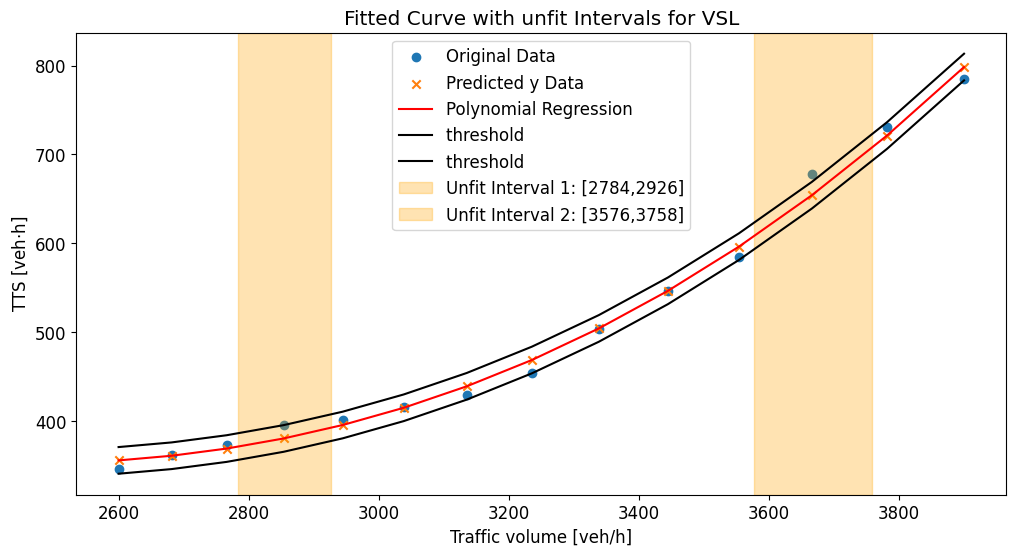

MAIN interval list from VAL: [[2783.6923076923076, 2926.4615384615386], [3576.3076923076924, 3758.4615384615386]]
Modifier...
[MODC]: intervals list:  [[2783.6923076923076, 2926.4615384615386], [3576.3076923076924, 3758.4615384615386]]
[MODC]: (interval_min_tick, interval_max_tick):  (2783.6923076923076, 2926.4615384615386)
[MODC]: mod_ticks:  [2800, 2875]
[MODC]: mod_x:  [2800.0, 2875.0]
[MODC]: (interval_min_tick, interval_max_tick):  (3576.3076923076924, 3758.4615384615386)
[MODC]: mod_ticks:  [3625, 3700]
[MODC]: mod_x:  [3625.0, 3700.0]
MAIN mod outcome ([[2800.0, 2875.0], [3625.0, 3700.0]], [[2783.6923076923076, 2926.4615384615386], [3576.3076923076924, 3758.4615384615386]])
Simulator...
[[2800.0, 2875.0], [3625.0, 3700.0]]
 IN SIMULATE: [[2800.0, 2875.0], [3625.0, 3700.0]]
Flatten mod_x [2800.0, 2875.0, 3625.0, 3700.0]
 len 90x list [2800.0, 2800.0, 2800.0, 2800.0, 2800.0, 2800.0, 2800.0, 2800.0, 2800.0, 2800.0, 2800.0, 2800.0, 2800.0, 2800.0, 2800.0, 2800.0, 2800.0, 2800.0, 280

Step #5400.00 (6ms ~= 41.67*RT, ~51166.67UPS, TraCI: 0ms, vehicles TOT 7079 ACT 307 BUF 0)
Step #5400.00 (6ms ~= 41.67*RT, ~72166.67UPS, TraCI: 0ms, vehicles TOT 7259 ACT 433 BUF 0)
Simulation output: [378.2777777777777, 390.90277777777777, 604.8472222222223, 699.5972222222224]
MODX [2800.0, 2875.0, 3625.0, 3700.0] and sim_y_list [378.2777777777777, 390.90277777777777, 604.8472222222223, 699.5972222222224]
MAIN modx [2800.0, 2875.0, 3625.0, 3700.0]
Validator...
What are POINTS  [[2800.0, 378.2777777777777], [2875.0, 390.90277777777777], [3625.0, 604.8472222222223], [3700.0, 699.5972222222224], [2853.846153846154, 395.5555555555556], [3666.153846153846, 678.402777777778]]
       *** USING local_exploration_validator_A


/home/amy/tmp/SimEx/notebooks/validator.py:44: RankWarning: Polyfit may be poorly conditioned
  current_coeff = np.polyfit(x_values, y_values, deg=degree)
/home/amy/tmp/SimEx/notebooks/validator.py:44: RankWarning: Polyfit may be poorly conditioned
  current_coeff = np.polyfit(x_values, y_values, deg=degree)
/home/amy/tmp/SimEx/notebooks/validator.py:44: RankWarning: Polyfit may be poorly conditioned
  current_coeff = np.polyfit(x_values, y_values, deg=degree)
/home/amy/tmp/SimEx/notebooks/validator.py:44: RankWarning: Polyfit may be poorly conditioned
  current_coeff = np.polyfit(x_values, y_values, deg=degree)
/home/amy/tmp/SimEx/notebooks/validator.py:44: RankWarning: Polyfit may be poorly conditioned
  current_coeff = np.polyfit(x_values, y_values, deg=degree)


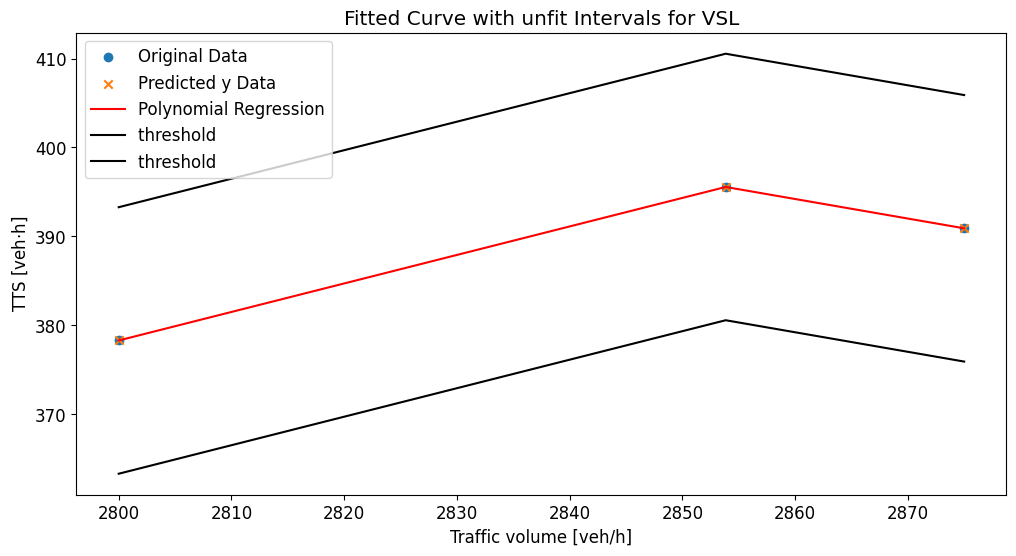

equation,
 y =  -1.3122899093893992e-17x^6  -1.2770545898277334e-16x^5 + 6.358086644578345e-11x^4 + 2.4285497450838745e-07x^3 + 0.0005247904533349774x^2 + 0.04548092502199785x^1  -6756.838058283177 
unfit_points
 [(2800.0, 378.2777777777777), (2853.846153846154, 395.5555555555556), (2875.0, 390.90277777777777)] 
local_unfit_interval
, [[2783.6923076923076, 2926.4615384615386]]
       *** USING local_exploration_validator_A


/home/amy/tmp/SimEx/notebooks/validator.py:44: RankWarning: Polyfit may be poorly conditioned
  current_coeff = np.polyfit(x_values, y_values, deg=degree)
/home/amy/tmp/SimEx/notebooks/validator.py:44: RankWarning: Polyfit may be poorly conditioned
  current_coeff = np.polyfit(x_values, y_values, deg=degree)
/home/amy/tmp/SimEx/notebooks/validator.py:44: RankWarning: Polyfit may be poorly conditioned
  current_coeff = np.polyfit(x_values, y_values, deg=degree)
/home/amy/tmp/SimEx/notebooks/validator.py:44: RankWarning: Polyfit may be poorly conditioned
  current_coeff = np.polyfit(x_values, y_values, deg=degree)
/home/amy/tmp/SimEx/notebooks/validator.py:44: RankWarning: Polyfit may be poorly conditioned
  current_coeff = np.polyfit(x_values, y_values, deg=degree)


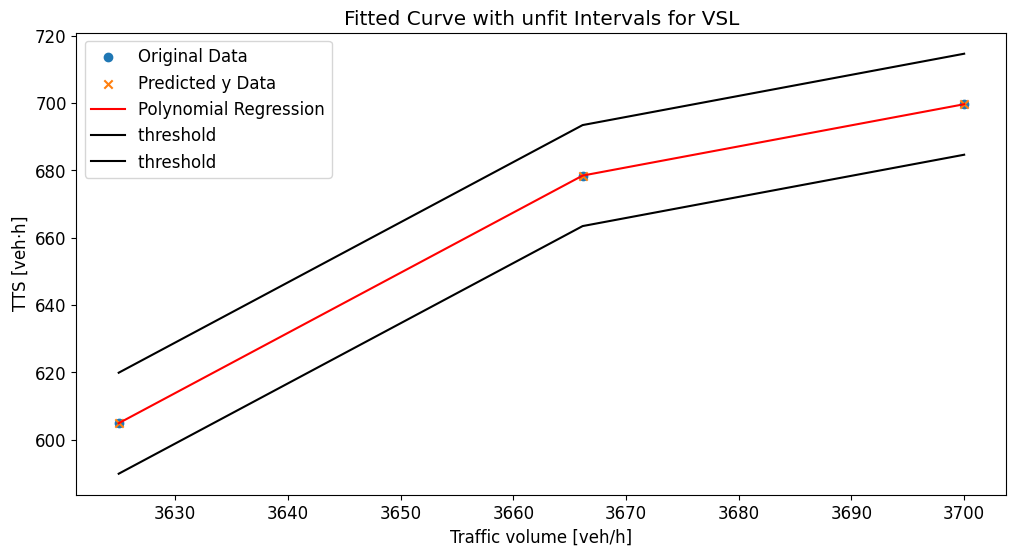

equation,
 y =  -1.0539782137064623e-17x^6 + 3.6775248119512886e-16x^5 + 8.709600553465462e-11x^4 + 4.231611877898748e-07x^3 + 0.0011594325885454252x^2  -0.01799073507205538x^1  -26076.863271455197 
unfit_points
 [(3625.0, 604.8472222222223), (3666.153846153846, 678.402777777778), (3700.0, 699.5972222222224)] 
local_unfit_interval
, [[3576.3076923076924, 3758.4615384615386]]
DIFFERENCES 
each_interval  [3576.3076923076924, 3758.4615384615386] 
new_unfit_interval   []
MAIN interval list from VAL: []
Data written to the csv file simex_output-VSL-20240724-112056.csv
FIT POINT: (2600.0, 346.13889)
FIT POINT: (2681.53846, 361.94444)
FIT POINT: (2766.15385, 372.5)
FIT POINT: (2800.0, 378.27778)
FIT POINT: (2853.84615, 395.55556)
FIT POINT: (2875.0, 390.90278)
FIT POINT: (2944.61538, 400.51389)
FIT POINT: (3038.46154, 415.47222)
FIT POINT: (3135.38462, 429.73611)
FIT POINT: (3235.38462, 454.18056)
FIT POINT: (3338.46154, 503.125)
FIT POINT: (3444.61538, 546.125)
FIT POINT: (3553.84615, 584.81

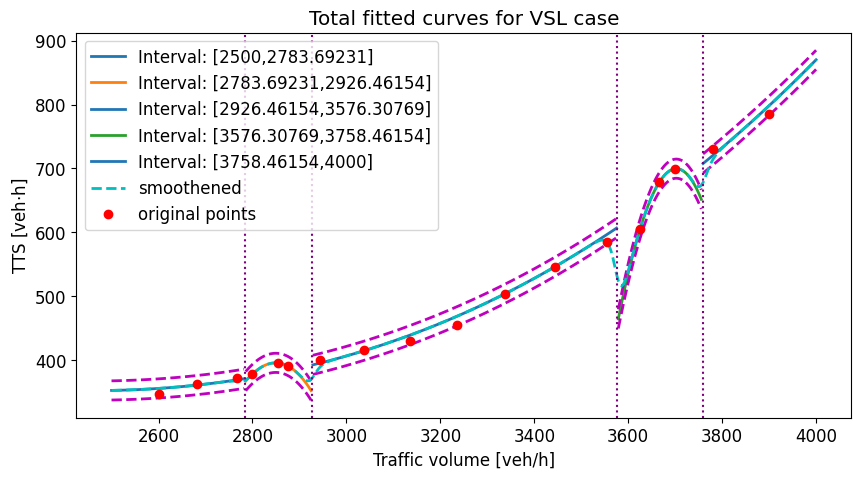

Figure was saved to total_function-VSL-20240724-112056.pdf
Run time: 10.382305518786113


In [2]:
# IMPORT LIBRARIES
import os
import numpy as np
# Set instance name 
os.environ['INSTANCE_NAME'] = 'VSL'

from global_settings import simexSettings, mds, timestamp

import pickle
import datetime
def save_object(obj, filename):
    with open(filename, 'wb') as outp:  # Overwrites any existing file.
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)

# Create directory for the results
script_dir = os.path.abspath('')
results_dir = os.path.join(script_dir, f'{simexSettings["results_dir"]}')

if not os.path.isdir(results_dir):
    os.makedirs(results_dir)

from components_configuration import components
from validator_controller import ValidatorController
from modifier_controller import ModifierController
from simulator_controller import SimulatorController
from logger_utils import Logger

validator_controller_vsl = ValidatorController()
logger = Logger()
logger_main_arguments = {}
is_main_func = True
# Initialize interval list for the first iteration
intervals_list=[[mds['domain_min_interval'], mds['domain_max_interval']]]

# Timestamp for the validator pickle file
count = 0
filename1 = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")


import time
before = time.time()

while is_main_func:
    
    # Calls Modifier Controller
    # NOTE: intervals_list type is set to np.int64 due to: https://github.com/numpy/numpy/issues/8433 on windows
    mod_outcome = ModifierController.control(intervals_list=intervals_list,selected_modifier=components['modifierA'], do_plot=simexSettings['do_plot'])
    mod_x_list = mod_outcome[0]
    checked_intervals = mod_outcome[1]
    print("MAIN mod outcome", mod_outcome)  

    
    # breaks loop if iterations end by granularity reached
    if not mod_x_list: # FALSE IF ['modifier_data_point'] < mdv['modifier_incremental_unit']:
        logger_main_arguments['log_contex'] = 'overall MAIN stats'
        logger_main_arguments['main_status'] = 'no generated points'
        logger_main_arguments['remaining_unfit_intervals'] = checked_intervals
        logger.log_main(logger_main_arguments)
        break
    
    # Calls Simulator
    mod_x,sim_y_list = SimulatorController.simulate_parallel(mod_x_list,selected_simulator=components['sumo_simulator_vsl'])
    print(f"MODX {mod_x} and sim_y_list {sim_y_list}")
    assert len(mod_x) == len(sim_y_list)
    print("MAIN modx", mod_x)  

    # Calls Validator controller
    intervals_list =  validator_controller_vsl.validate(mod_x_list=np.array(mod_x),sim_y_list=np.array(sim_y_list), selected_validator=components['validator'],global_interval=[mds["domain_min_interval"], mds["domain_max_interval"]])
    print("MAIN interval list from VAL:", intervals_list)
    # Loop number ( Loop-1,Loop-2..etc)
    count +=1
    save_object(validator_controller_vsl,os.path.join(simexSettings['results_dir'],f"vc_{os.environ['INSTANCE_NAME']}_loop-{count}-{timestamp}.pkl"))
    
    # Updates interval_list to new range output from validator controller
    # No more unfit intervals -> write MAIN log
    if not intervals_list:
        is_main_func = False
        logger_main_arguments['log_contex'] = 'overall MAIN stats'
        logger_main_arguments['main_status'] = 'no unfit intervals'
        logger.log_main(logger_main_arguments)

# MAIN cycle completed/interrupted -> write OVERALL statistics        
logger_main_arguments['log_contex'] = 'Overall Stats'                          
logger_main_arguments['main_status'] = 'end cycle'
logger.log_main(logger_main_arguments)

now = time.time()
print(f"Run time: {(now-before)/60}")

In [2]:
import os
os.environ['INSTANCE_NAME'] = 'VSL'
# Save data for the last plot located in logger object
save_object(logger.all_fit_intervals_data,f"logger-{os.environ['INSTANCE_NAME']}-fitted_intervals-{filename1}.pkl")
# If not empty
if logger.remaining_unfit_intervals:
    save_object(logger.remaining_unfit_intervals,f"logger-{os.environ['INSTANCE_NAME']}-unfitted_intervals-{filename1}.pkl")
print(f"Logger object saved with timestamp {filename1}")

Logger object saved with timestamp 20240723-151007


## Edit final curve plot from logger object

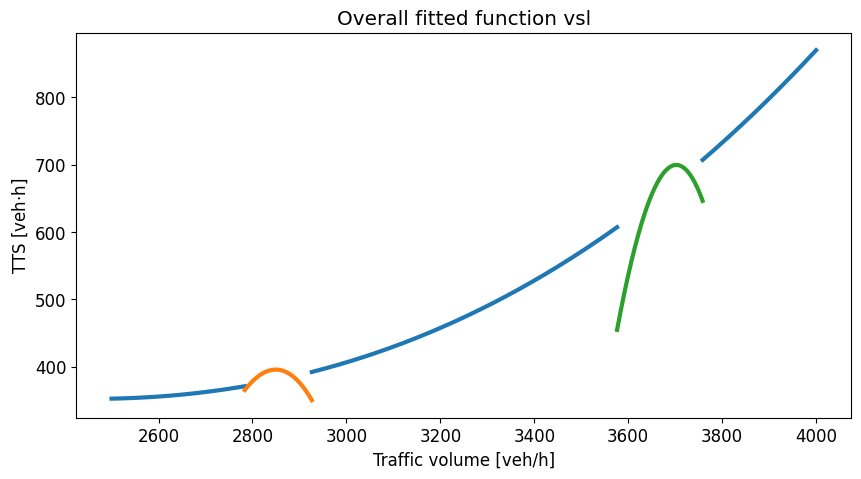

In [3]:
import re
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
from global_settings import lgs, mgs


all_fit_intervals_data = logger.all_fit_intervals_data
remaining_unfit_intervals = logger.remaining_unfit_intervals
_, ax = plt.subplots(figsize=(10, 5))

colors = {}
# Plot FI intervals with their fitting functions
for element in all_fit_intervals_data:
    interval = element['interval']
    fitting_function_str = element['fitting_function']

    # Convert the string into a function
    terms = re.findall(
        r'([+-]?\s*\d+\.?\d*(?:e[+-]?\d+)?)(x\^\d+)?', fitting_function_str.replace(' ', ''))
    coefficients = [0] * 10  # Initialize a list of 10 zeros
    for term in terms:
        coef = float(term[0])
        if term[1]:  # If there is an 'x' term
            exponent = int(term[1][2:])  # Get the exponent
            while len(coefficients) <= exponent:  # Expand the list if needed
                coefficients.append(0)
            # Assign the coefficient to the corresponding position in the list
            coefficients[exponent] = coef
        else:  # If there is no 'x' term, it's the constant term
            coefficients[0] = coef
    # Reverse the list to match the order expected by np.poly1d
    fitting_function = np.poly1d(coefficients[::-1])

    # Adjust the number of points as needed
    x = np.linspace(interval[0], interval[1], 400)
    y = fitting_function(x)
    if fitting_function_str in colors.keys():
        ax.plot(x, y, linewidth=3, label=f'Interval vsl: [{round(interval[0]), round(interval[1])}]',
            color=colors[fitting_function_str])
    else:
        ax.plot(x, y, linewidth=3, label=f'Interval vsl: [{round(interval[0]), round(interval[1])}]')
        color = ax.get_lines()[-1].get_color()
        colors[fitting_function_str] = color

for element in remaining_unfit_intervals:
    ax.axvspan(*element['interval'], color='gray',
               alpha=0.3, label='unfit Interval')
plt.title("Overall fitted function vsl")
plt.xlabel('Traffic volume [veh/h]')
plt.ylabel('TTS [veh$\cdot$h]')
plt.savefig(f"total_function-vsl.pdf", format='pdf')



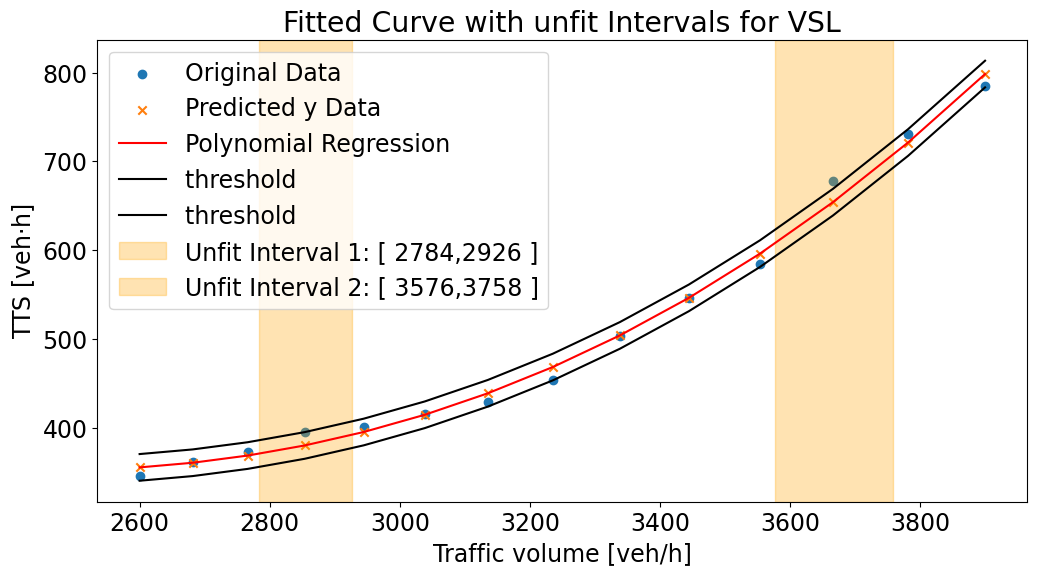

In [4]:
import matplotlib
from global_settings import vfs
import pickle
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
# vsl = validator_controller_vsl
# nvsl = validator_controller_novsl

# Uncomment to read the validator_controller object from file to plot curves
# Figures for the paper
#vsl = pickle.load(open("vc_novsl_loop-1-20240605-173339.pkl", "rb"))
vsl = pickle.load(open("vc_vsl_loop-1-20240605-173349.pkl", "rb"))
# nvsl = pickle.load(open("vc_vsl_loop-3-20240602-230447.pkl", "rb"))

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42


plt.rcParams.update({'font.size': 17})

# Plot for vsl
#for controller in [validator_controller_vsl,validator_controller_novsl]:
# controller= validator_controller_novsl
#    print(f"X values and Y values {controller.x_values}{controller.y_values} predicted values {controller.predicted_values}")
#    plt.scatter(controller.x_values, controller.y_values, label=f'Original Data ')
#    plt.scatter(controller.x_values, controller.predicted_values, label=f'Predicted y Data ', marker='x')
#    plt.plot(controller.fitted_curve[2], controller.fitted_curve[1], color='red', label=f'Polynomial Regression')
#    plt.plot(controller.fitted_curve[2], controller.fitted_curve[1] + vfs["threshold_y_fitting"], color='black', label=f'threshold ')
#    plt.plot(controller.fitted_curve[2], controller.fitted_curve[1] - vfs["threshold_y_fitting"], color='black', label=f'threshold ')

plt.scatter(vsl.x_values, vsl.y_values, label=f'Original Data ')
plt.scatter(vsl.x_values, vsl.predicted_values, label=f'Predicted y Data ', marker='x')
plt.plot(vsl.fitted_curve[2], vsl.fitted_curve[1], color='red', label=f'Polynomial Regression')
plt.plot(vsl.fitted_curve[2], vsl.fitted_curve[1] + vfs["threshold_y_fitting"], color='black', label=f'threshold ')
plt.plot(vsl.fitted_curve[2], vsl.fitted_curve[1] - vfs["threshold_y_fitting"], color='black', label=f'threshold ')

# plt.scatter(nvsl.x_values, nvsl.y_values, label=f'Original Data ')
# plt.scatter(nvsl.x_values, nvsl.predicted_values, label=f'Predicted y Data ', marker='x')
# plt.plot(nvsl.fitted_curve[2], nvsl.fitted_curve[1], color='blue', label=f'Polynomial Regression novsl')
#plt.plot(nvsl.fitted_curve[2], nvsl.fitted_curve[1] + vfs["threshold_y_fitting"], color='black', label=f'threshold ')
#plt.plot(nvsl.fitted_curve[2], nvsl.fitted_curve[1] - vfs["threshold_y_fitting"], color='black', label=f'threshold ')
count = 0
for start, end in vsl.unfit_interval:
    count += 1
    plt.axvspan(start, end, color='orange',alpha=0.3, label=f'Unfit Interval {count}: [ {round(start)},{round(end)} ]')


plt.xlabel('Traffic volume [veh/h]')
plt.ylabel('TTS [veh$\cdot$h]')
plt.title(f'Fitted Curve with unfit Intervals for VSL')
plt.legend()
#plt.show()
plt.savefig(f"test.pdf", format='pdf')